In [101]:
import numpy as np
import os
import pandas as pd

# find target path for data files, assuming the notebook is in the right place
data_path = _dh[0]
assert data_path.endswith(os.path.join('em-2020','data'))

output_path = os.path.join(data_path, 'combined_dataset_raw.csv')

In [102]:
country_groups = pd.read_excel(os.path.join(data_path, 'CLASS.xls'), sheet_name='Groups')
country_group_map = {k: set(v['CountryCode']) for k, v in country_groups.groupby('GroupCode')}
all_countries = country_group_map['WLD']

In [103]:
wdi_path = os.path.join(data_path, 'WDI_reshaped.csv')
wdi_data = pd.read_csv(wdi_path).set_index(['Country Code', 'Year'])
is_country = wdi_data.index.get_level_values('Country Code').isin(all_countries)

wipo_path = os.path.join(data_path, 'WIPO_reshaped.csv')
wipo_data = pd.read_csv(wipo_path).set_index(['Country Code', 'Year'])
assert set(all_countries).issuperset(wipo_data.index.levels[0])

chinn_ito_path = os.path.join(data_path, 'ChinnIto_reshaped.csv')
chinn_ito_data = pd.read_csv(wipo_path).set_index(['Country Code', 'Year'])
assert set(all_countries).issuperset(chinn_ito_data.index.levels[0])

## Copy over raw data/simple transformations:

In [104]:
combined = pd.DataFrame()
combined['ENI'] = 1. / wdi_data['EG.GDP.PUSE.KO.PP.KD']
combined['POP'] = wdi_data['EN.POP.DNST']
combined['URB'] = wdi_data['SP.URB.TOTL.IN.ZS']
combined['AFL'] = wdi_data['NY.GDP.PCAP.PP.KD']

In [105]:
combined.xs('FRA', level='Country Code', drop_level=False).tail()

ENI         POP     URB           AFL
Country Code Year                                           
FRA          2015  0.08477  121.536704  79.655  43553.399292
             2016      NaN  121.857825  79.917  43914.481647
             2017      NaN  122.114008  80.180  44826.507474
             2018      NaN  122.299437  80.444  45561.001768
             2019      NaN         NaN  80.709  46183.521790

## Combine WB WDI and WIPO patent data

In [106]:
wb_patents = wdi_data[['IP.PAT.RESD', 'IP.PAT.NRES']].sum(axis='columns')
wipo_patents = wipo_data['WIPO patents']

patent_df = pd.DataFrame({'WB': wb_patents, 'WIPO': wipo_patents})
patent_df.replace(0., np.nan, inplace=True)
missing = patent_df.isnull().any(axis=1) 
mismatch = ~missing & (patent_df['WB'] != patent_df['WIPO'])

In [107]:
patent_df.loc[mismatch]

,,WB,WIPO
Country Code,Year,,


In [108]:
patent_df.loc[~patent_df['WB'].isnull() 
              & patent_df['WIPO'].isnull()
             ].drop('WLD', level='Country Code')

WB  WIPO
Country Code Year             
COD          1980  103.0   NaN
             1981   82.0   NaN
             1982   99.0   NaN
             1983   72.0   NaN
             1984   94.0   NaN

In [109]:
patent_df.loc[~patent_df['WIPO'].isnull() 
              & patent_df['WB'].isnull()
             ]

WB   WIPO
Country Code Year           
ALB          1993 NaN   16.0
             1994 NaN    8.0
             1995 NaN    5.0
             1996 NaN    5.0
             1998 NaN   21.0
...                ..    ...
SYR          2016 NaN  112.0
YEM          2008 NaN   85.0
             2009 NaN   72.0
ZWE          2013 NaN   23.0
             2014 NaN   27.0

[165 rows x 2 columns]

## Convert patent count to per capita measure

In [110]:
patent_count = patent_df['WB'].combine_first(patent_df['WIPO'])
combined['TI'] = patent_count / wdi_data['SP.POP.TOTL']

In [111]:
combined.xs('FRA', level='Country Code', drop_level=False).tail()

ENI         POP     URB           AFL        TI
Country Code Year                                                     
FRA          2015  0.08477  121.536704  79.655  43553.399292  0.000245
             2016      NaN  121.857825  79.917  43914.481647  0.000243
             2017      NaN  122.114008  80.180  44826.507474  0.000243
             2018      NaN  122.299437  80.444  45561.001768  0.000242
             2019      NaN         NaN  80.709  46183.521790       NaN

## Construct Squalli and Wilson (2011) CTS indicator

In [133]:
country_data = wdi_data.loc[is_country]
trade = country_data['NE.IMP.GNFS.CD'] + country_data['NE.EXP.GNFS.CD']
gdp = country_data['NY.GDP.MKTP.CD']
TS = trade / gdp
TS.loc[pd.IndexSlice[['USA'], 1999:2001]]

Country Code  Year
USA           1999    0.232735
              2000    0.250436
              2001    0.228430
dtype: float64

In [147]:
pwt_raw = pd.read_excel(os.path.join(data_path, 'pwt91.xlsx'), sheet_name='Data')

In [149]:
pwt_data = pwt_raw.set_index(['countrycode', 'year'])
pwt_data.index.names = ['Country Code', 'Year']
pwt_data.loc[pd.IndexSlice[['USA'], 1999:2001], ['csh_x', 'csh_m', 'rgdpna']]

csh_x     csh_m      rgdpna
Country Code Year                                
USA          1999  0.093493 -0.134178  12373193.0
             2000  0.107020 -0.157752  12883895.0
             2001  0.101320 -0.152584  13012520.0

In [155]:
TS = pwt_data['csh_x'] - pwt_data['csh_m']
trade = TS * pwt_data['rgdpna']
TS.loc[pd.IndexSlice[['USA'], 1999:2001]]

Country Code  Year
USA           1999    0.227670
              2000    0.264772
              2001    0.253905
dtype: float64

In [156]:
world_trade = trade.groupby(level='Year').sum()
WTS = trade.groupby(level='Country Code').transform(lambda x: x.divide(world_trade))
WTS.loc[pd.IndexSlice[['USA'], 1999:2001]]

Country Code  Year
USA           1999    0.120889
              2000    0.125465
              2001    0.121223
dtype: float64

In [122]:
WTS_mean = WTS.groupby(level='Year').mean()
WTS_mean.loc[1999:2001]

Year
1999    0.005848
2000    0.005682
2001    0.005682
dtype: float64

In [123]:
relative_WTS = WTS.divide(WTS_mean)
relative_WTS.loc[pd.IndexSlice[['USA'], 1999:2001]]

Country Code  Year
USA           1999    27.943636
              2000    29.626372
              2001    28.442691
dtype: float64

In [124]:
CTS = relative_WTS.multiply(TS)
CTS.loc[pd.IndexSlice[['USA'], 1999:2001]]

Country Code  Year
USA           1999    6.503455
              2000    7.419520
              2001    6.497152
dtype: float64

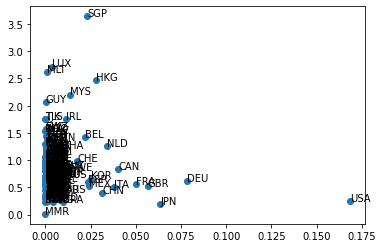

In [131]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots()
z, y = WTS.xs(2000, level='Year'), TS.xs(2000, level='Year')
ax.scatter(z, y)
for c in z.index:
    ax.annotate(c, (z[c], y[c]))